In [1]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import glob
import xesmf as xe
import cartopy.feature as feature

In [2]:
model_file = 'tos_Omon_IPSL-CM6A-LR_historical_r12i1p1f1_gn_185001-201412.nc'

In [4]:
ds = xr.open_dataset(model_file)
ds

<xarray.Dataset>
Dimensions:         (y: 332, x: 362, nvertex: 4, time: 1980, axis_nbounds: 2)
Coordinates:
    nav_lat         (y, x) float32 ...
    nav_lon         (y, x) float32 ...
  * time            (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T...
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    bounds_nav_lon  (y, x, nvertex) float32 ...
    bounds_nav_lat  (y, x, nvertex) float32 ...
    area            (y, x) float32 ...
    time_bounds     (time, axis_nbounds) datetime64[ns] ...
    tos             (time, y, x) float32 ...
Attributes: (12/50)
    name:                   /ccc/work/cont003/gencmip6/p86denv/IGCM_OUT/IPSLC...
    Conventions:            CF-1.7 CMIP-6.2
    creation_date:          2018-08-10T18:47:49Z
    tracking_id:            hdl:21.14100/4799a67f-5401-44ab-9727-5bd41f99d2d5
    description:            CMIP6 historical
    title:                  IPSL-CM6A-LR model output prepared for CMIP6 / CM...
    ...                     ...
    EXPID:                  historical
    CMIP6_CV_version:       cv=6.2.3.5-2-g63b123e
    dr2xml_md5sum:          523ab9c7b70cfe3bc2c825d1e555e1d0
    model_version:          6.1.5
    parent_variant_label:   r1i1p1f1
    history:                Tue Sep  4 11:11:09 2018: ncatted -O -a parent_va...

In [5]:
new_lat=np.arange(-90,90.5,0.5)
new_lon=np.arange(0,360.1,0.1)

ds_out = xr.Dataset({'lat': (['lat'], new_lat),
                    'lon': (['lon'], new_lon)
                    })
ds_out

<xarray.Dataset>
Dimensions:  (lat: 361, lon: 3601)
Coordinates:
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 0.0 0.1 0.2 0.3 0.4 ... 359.6 359.7 359.8 359.9 360.0
Data variables:
    *empty*

In [6]:
regridder = xe.Regridder(ds, ds_out,'bilinear', ignore_degenerate=True)
dr_out = regridder(ds['tos']).to_dataset(name='tos')
dr_out

<xarray.Dataset>
Dimensions:  (time: 1980, lat: 361, lon: 3601)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 0.0 0.1 0.2 0.3 0.4 ... 359.6 359.7 359.8 359.9 360.0
Data variables:
    tos      (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan

In [8]:
monthly_mean = dr_out.groupby('time.month').mean(dim='time')
max_value = monthly_mean.max()
min_value = monthly_mean.min()
print(f"Maximum value: {max_value}")
print(f"Minimum value: {min_value}")

Maximum value: <xarray.Dataset>
Dimensions:  ()
Data variables:
    tos      float64 33.27
Minimum value: <xarray.Dataset>
Dimensions:  ()
Data variables:
    tos      float64 -1.949


<Figure size 1100x850 with 0 Axes>

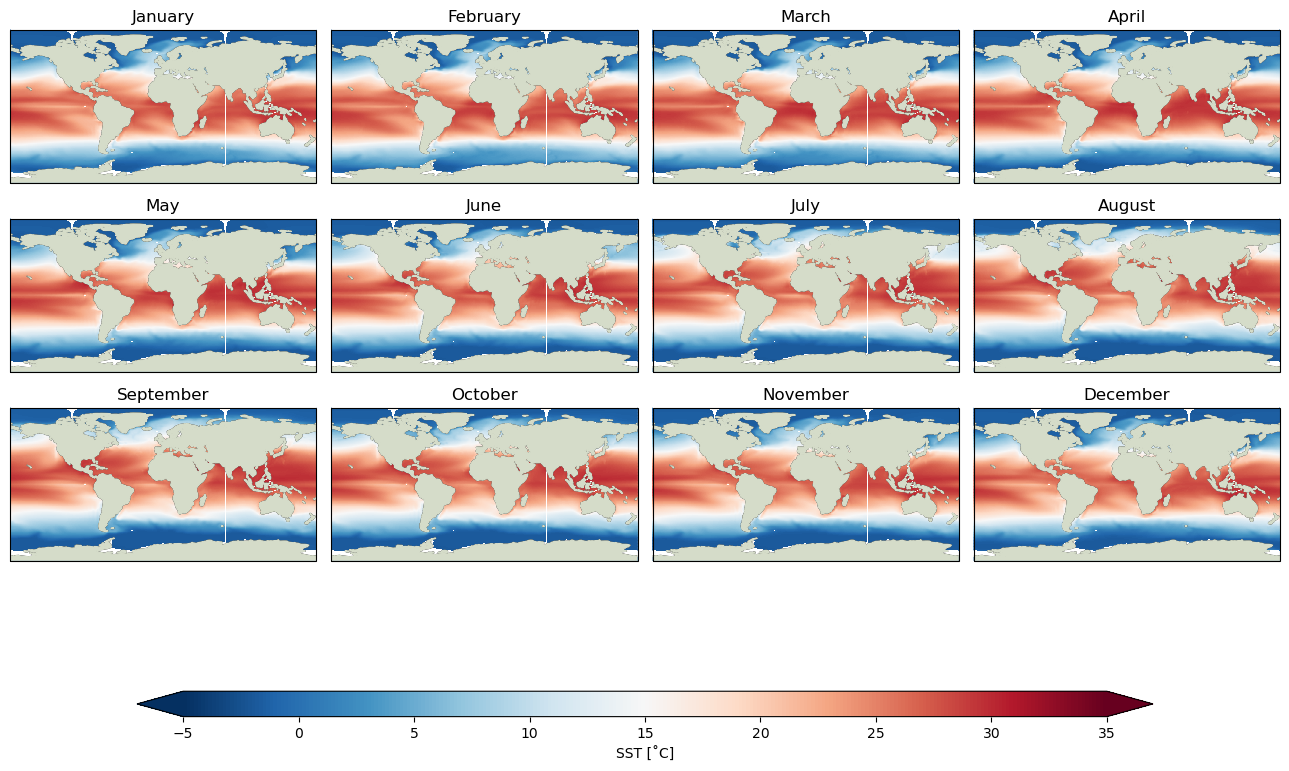

In [10]:
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']

fig = plt.figure(figsize=(11,8.5))

fg = monthly_mean['tos'].plot(x='lon',y='lat',col='month',col_wrap=4,
    cmap='RdBu_r',extend='both',
    vmin=-5, vmax=35, 
    subplot_kws={"projection": ccrs.PlateCarree()},
    cbar_kwargs={
        "orientation": "horizontal",
        "shrink": 0.8,
        "aspect": 40,
        "label": "SST [˚C]",
    },)

for i, ax in enumerate(fg.axes.flat):
    ax.set_title(month_names[i])  
    ax.coastlines()
    ax.add_feature(feature.LAND, zorder=2, color='#D5DCC9')
